In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from keras.models import Model
import math

import config

In [2]:
def plot_confusion_matrix(model, ds, label_names):
    y_pred = []
    y_true = []
    for batch in ds.as_numpy_iterator():
        imgs, labels = batch
        out = model.predict(imgs)
        for i in range(len(labels)):
            y_pred.append(np.argmax(out[i]))
            y_true.append(np.argmax(labels[i]))
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Oranges')

# plot history of training
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['categorical_accuracy'], label='accuracy')
    plt.plot(history['val_categorical_accuracy'], label='val_accuracy')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [3]:
# Load the data
_, _, eval_ds = config.get_datasets()

0.03s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Found 3764 files belonging to 7 classes.


2024-12-01 18:23:10.749986: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-12-01 18:23:10.750038: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-01 18:23:10.750057: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-01 18:23:10.750341: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 18:23:10.750517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model loading

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(config.image_size[0], config.image_size[1], 1)))

# Preprocessing
model.add(keras.layers.RandomTranslation(0.1, 0.1))
model.add(keras.layers.RandomBrightness(0.1))
model.add(keras.layers.RandomContrast(0.1))

# Rescale the pixel values
model.add(keras.layers.Rescaling(1./255))

# Convolutional layers
model.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())

# Dense Layers
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(config.n_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy(),
                              keras.metrics.AUC(),
                              keras.metrics.F1Score(), 
                              keras.metrics.Precision(),
                              keras.metrics.Recall()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_translation              │ (None, 128, 128, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 128, 128, 1)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,479 (8.09 MB)

 Trainable params: 2,121,479 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

/Users/mariapolak/miniconda3/envs/mlme/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 21 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - auc: 0.8592 - categorical_accuracy: 0.5556 - f1_score: 0.5406 - loss: 1.3670 - precision: 0.6124 - recall: 0.4353
Test Loss: 1.4604424238204956
Test Accuracy: 0.5173267126083374
Test AUC: 0.8429008722305298
Test F1 Score: [0.49999994 0.59322023 0.4938271  0.6901408  0.32812494 0.49152535
 0.49572644]
Test Precision: 0.5750916004180908
Test Recall: 0.38861384987831116
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


2024-12-01 18:35:34.952395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


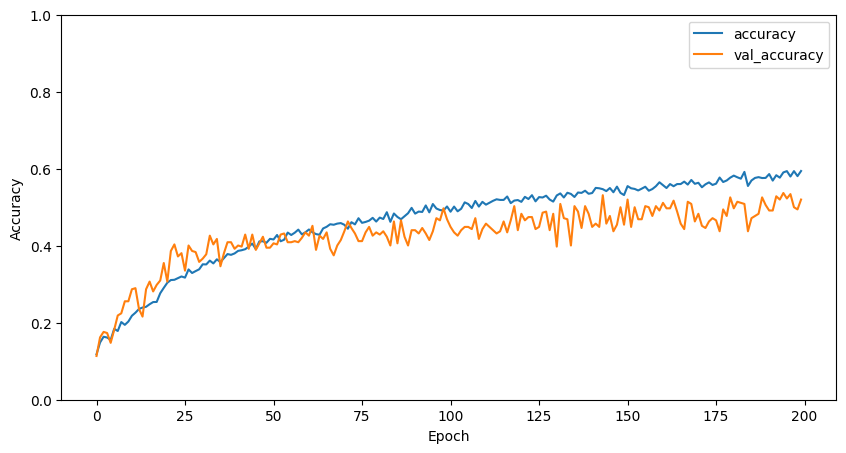

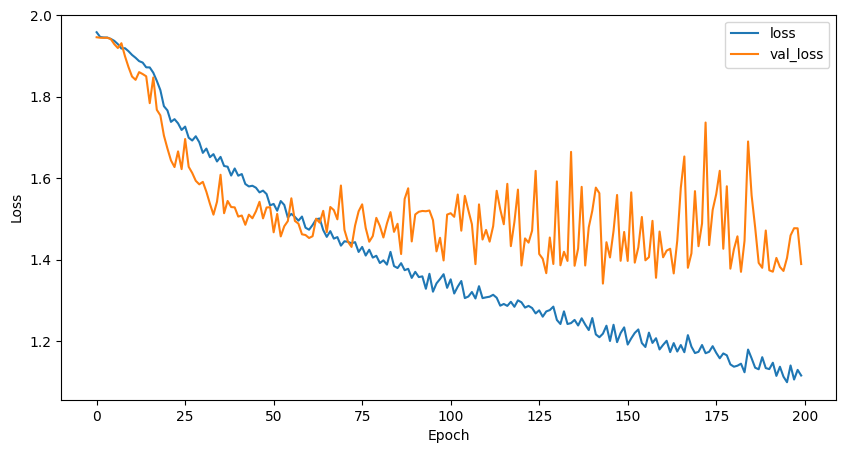

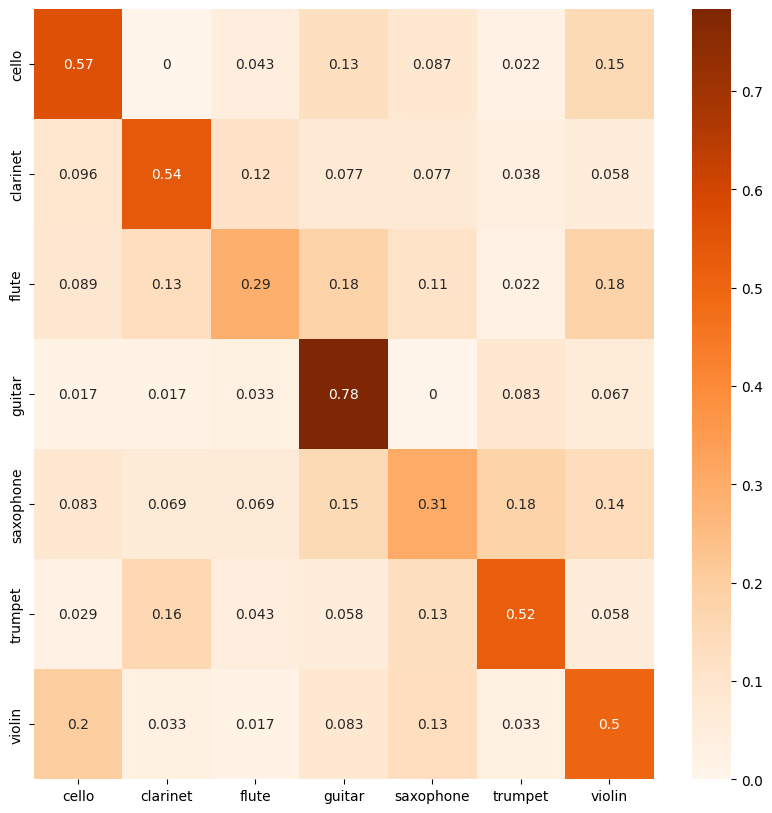

In [16]:
model.load_weights("results/adam-1e3-conv1/instrument-recognition.weights.h5")
history=np.load('results/adam-1e3-conv1/history.npy',allow_pickle='TRUE').item()
plot_history(history)
results = model.evaluate(eval_ds)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")
print(f"Test F1 Score: {results[3]}")
print(f"Test Precision: {results[4]}")
print(f"Test Recall: {results[5]}")

plot_confusion_matrix(model, eval_ds, config.label_names)

In [17]:
model2 = keras.Sequential()
model2.add(keras.Input(shape=(config.image_size[0], config.image_size[1], 1)))

# Preprocessing
model2.add(keras.layers.RandomTranslation(0.1, 0.1))
model2.add(keras.layers.RandomBrightness(0.1))
model2.add(keras.layers.RandomContrast(0.1))

# Rescale the pixel values
model2.add(keras.layers.Rescaling(1./255))

# Convolutional layers
model2.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D())
model2.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D())
model2.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D())
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Flatten())

# Dense Layers
model2.add(keras.layers.Dense(128, activation='relu'))
model2.add(keras.layers.Dense(config.n_classes, activation='softmax'))

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy(),
                              keras.metrics.AUC(),
                              keras.metrics.F1Score(), 
                              keras.metrics.Precision(),
                              keras.metrics.Recall()])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_translation_1            │ (None, 128, 128, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 128, 128, 1)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,169,975 (8.28 MB)

 Trainable params: 2,169,975 (8.28 MB)

 Non-trainable params: 0 (0.00 B)

/Users/mariapolak/miniconda3/envs/mlme/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 33 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - auc_1: 0.5000 - categorical_accuracy: 0.1143 - f1_score: 0.0291 - loss: 1.9460 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Test Loss: 1.9460597038269043
Test Accuracy: 0.12871287763118744
Test AUC: 0.5
Test F1 Score: [0.         0.22807015 0.         0.         0.         0.
 0.        ]
Test Precision: 0.0
Test Recall: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


2024-12-01 18:39:23.504097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


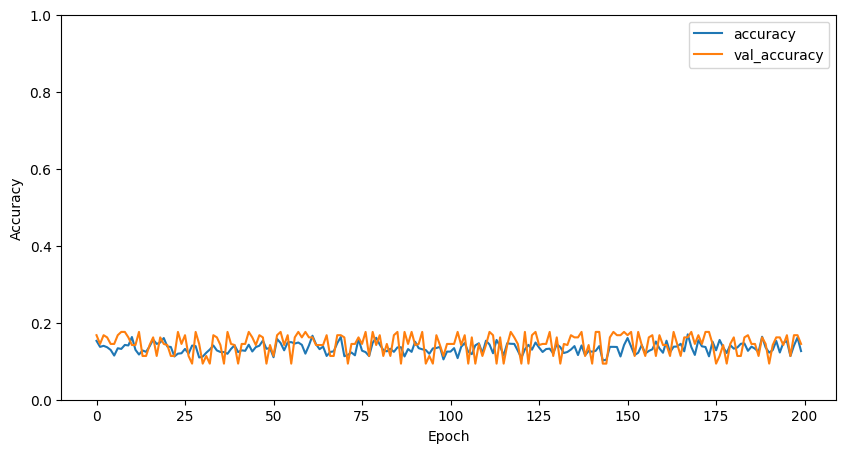

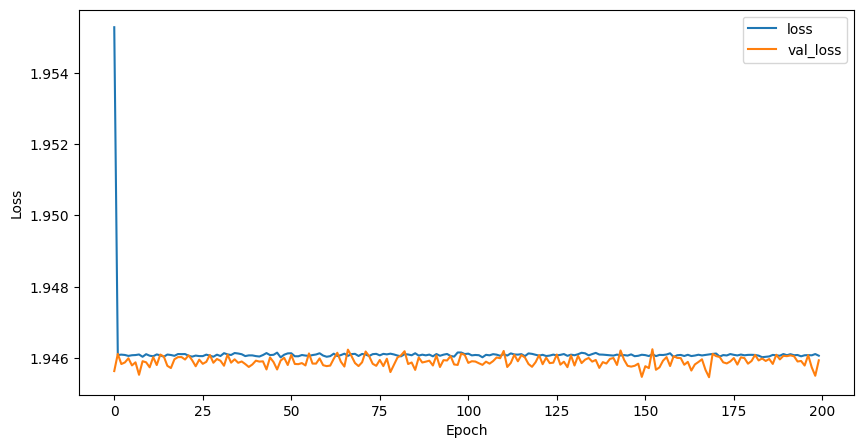

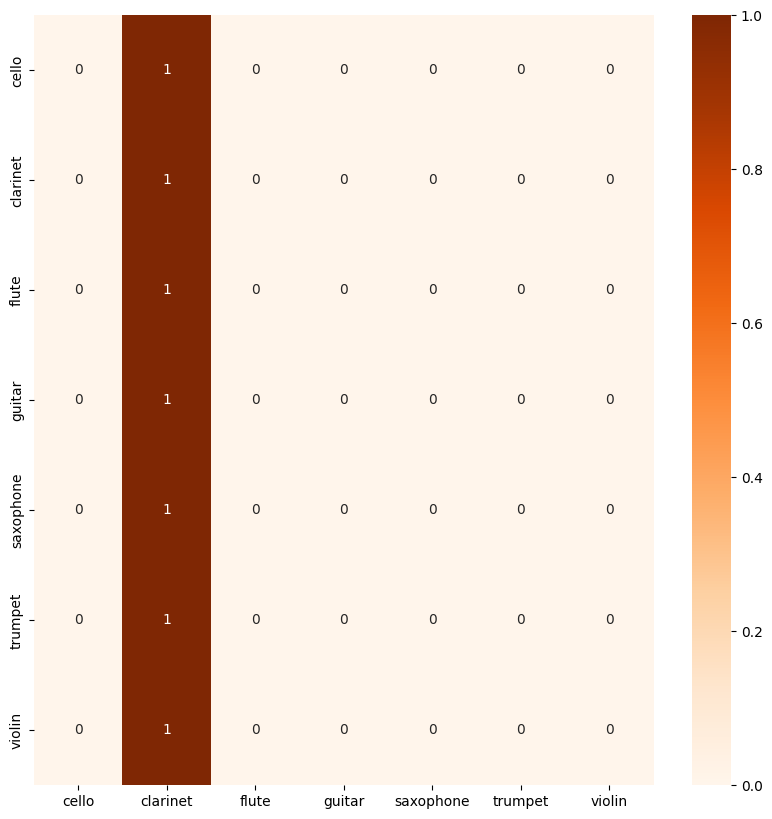

In [18]:
model2.load_weights("results/adam-1e3-conv2/instrument-recognition.weights.h5")
history=np.load('results/adam-1e3-conv2/history.npy',allow_pickle='TRUE').item()
plot_history(history)
results = model2.evaluate(eval_ds)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")
print(f"Test F1 Score: {results[3]}")
print(f"Test Precision: {results[4]}")
print(f"Test Recall: {results[5]}")

plot_confusion_matrix(model2, eval_ds, config.label_names)

In [19]:
model3 = keras.Sequential()
model3.add(keras.Input(shape=(config.image_size[0], config.image_size[1], 1)))

# Preprocessing
model3.add(keras.layers.RandomTranslation(0.1, 0.1))
model3.add(keras.layers.RandomBrightness(0.1))
model3.add(keras.layers.RandomContrast(0.1))

# Rescale the pixel values
model3.add(keras.layers.Rescaling(1./255))

# Convolutional layers
model3.add(keras.layers.Conv2D(16,3, padding='same', activation='relu'))
model3.add(keras.layers.MaxPooling2D())
model3.add(keras.layers.Conv2D(32,3, padding='same', activation='relu'))
model3.add(keras.layers.MaxPooling2D())
model3.add(keras.layers.Conv2D(64,3, padding='same', activation='relu'))
model3.add(keras.layers.MaxPooling2D())
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Flatten())

# Dense Layers
model3.add(keras.layers.Dense(128, activation='relu'))
model3.add(keras.layers.Dense(config.n_classes, activation='softmax'))

model3.compile(optimizer=keras.optimizers.SGD(), 
                     loss='categorical_crossentropy', 
                     metrics=[keras.metrics.CategoricalAccuracy(),
                              keras.metrics.AUC(),
                              keras.metrics.F1Score(), 
                              keras.metrics.Precision(),
                              keras.metrics.Recall()])

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_translation_2            │ (None, 128, 128, 1)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_2             │ (None, 128, 128, 1)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 128, 128, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,479 (8.09 MB)

 Trainable params: 2,121,479 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - auc_2: 0.8558 - categorical_accuracy: 0.5307 - f1_score: 0.4996 - loss: 1.3137 - precision_2: 0.6551 - recall_2: 0.3650
Test Loss: 1.364874005317688
Test Accuracy: 0.5198019742965698
Test AUC: 0.8443810939788818
Test F1 Score: [0.5128205  0.56451607 0.46575338 0.6764705  0.31067955 0.52702695
 0.5068493 ]
Test Precision: 0.6540284156799316
Test Recall: 0.34158414602279663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


2024-12-01 19:19:39.989566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


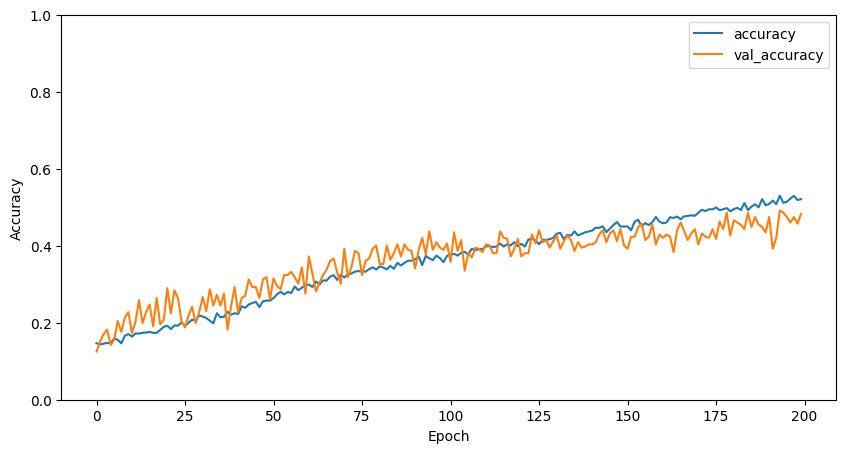

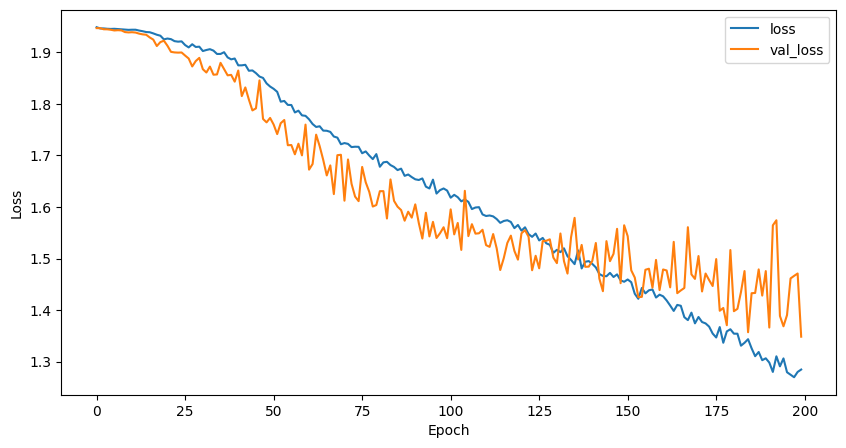

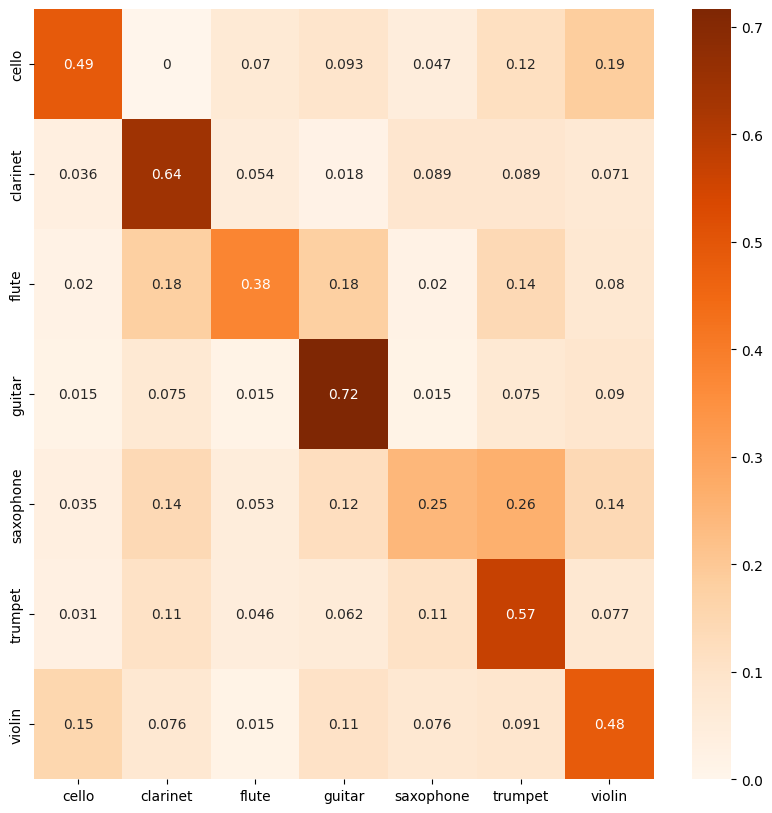

In [22]:
model3.load_weights("results/sgd-1e2-conv1/instrument-recognition.weights.h5")
history=np.load('results/sgd-1e2-conv1/history.npy',allow_pickle='TRUE').item()
plot_history(history)
results = model3.evaluate(eval_ds)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")
print(f"Test F1 Score: {results[3]}")
print(f"Test Precision: {results[4]}")
print(f"Test Recall: {results[5]}")

plot_confusion_matrix(model3, eval_ds, config.label_names)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc_2: 0.8774 - categorical_accuracy: 0.5679 - f1_score: 0.5626 - loss: 1.4195 - precision_2: 0.6338 - recall_2: 0.5191
Test Loss: 1.4749423265457153
Test Accuracy: 0.5495049357414246
Test AUC: 0.8687235713005066
Test F1 Score: [0.47191006 0.5544554  0.4631578  0.7669172  0.48275858 0.5357142
 0.51851845]
Test Precision: 0.6130030751228333
Test Recall: 0.4900990128517151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-12-01 19:30:32.078133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


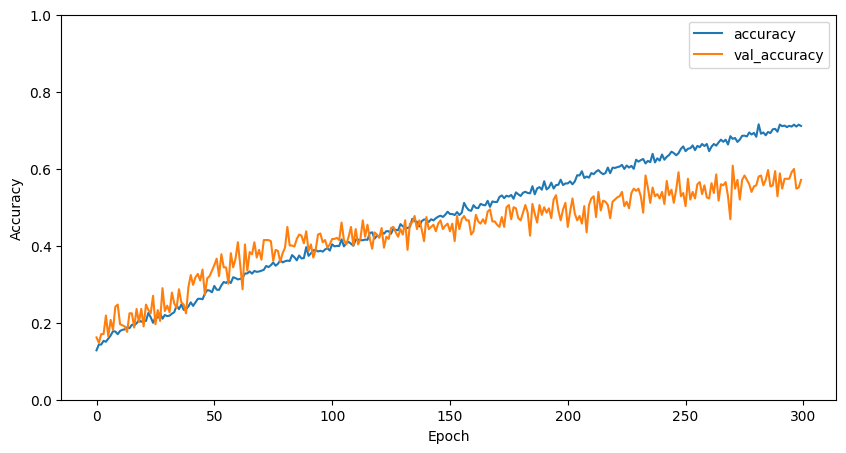

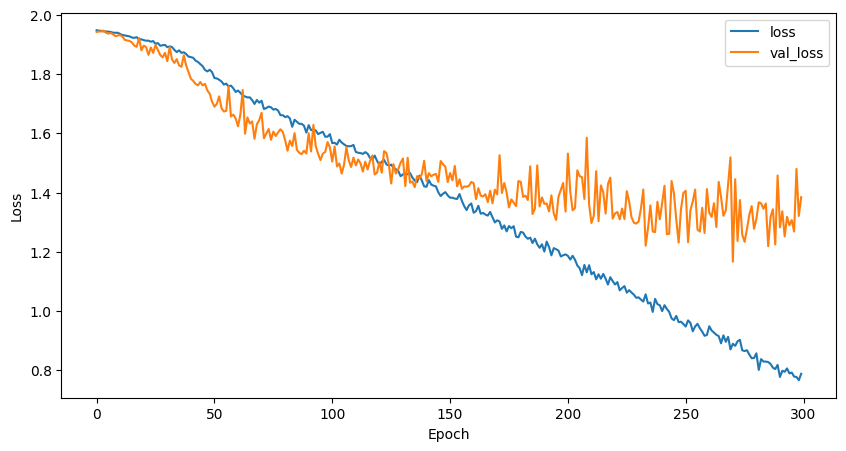

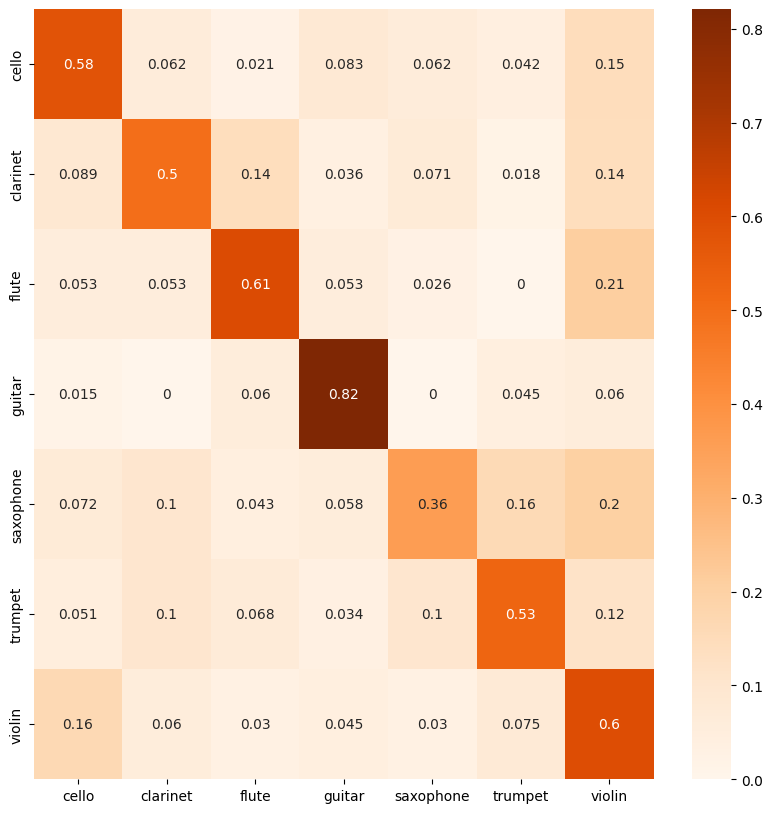

In [26]:
model3.load_weights("results/sgd-1e2-conv1-300e/instrument-recognition.weights.h5")
history=np.load('results/sgd-1e2-conv1-300e/history.npy',allow_pickle='TRUE').item()
plot_history(history)
results = model3.evaluate(eval_ds)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")
print(f"Test F1 Score: {results[3]}")
print(f"Test Precision: {results[4]}")
print(f"Test Recall: {results[5]}")

plot_confusion_matrix(model3, eval_ds, config.label_names)